Exploring music listening trends with Spotify by Asare Buahin

Abrstract 

My research question for the project is: How can I make a readily available report that can give me and other Spotify users an insightful look into their music listening habits? In answering this question, the biggest issue I ran into was creating an efficient data pipeline that can consistently be recreated weekly/monthly to collect data. Gaining insight developing captiavating visualizations however was not a problem. The data that I found was suprisingly hard to pull was genre data of the songs on Spotify. I was able to the spotipy package to collect audio features such as "valence" or "danceability" but ran into many timeout errors, so I had to partition the large dataframe and space out the number of requests I made using the Spotify Web API. Ultimately, I was able to get good insights into listening history over the past 5 years, and there is a lot of room for improvement in the depth of the report I have made.

Introduction

As an avid music listener, like most people are these days, I always find myself impatientily waiting for the start of December every year in anticipation of “Spotify Wrapped”. Spotify gives its users insightful information into the music they listened to in the past year. Each year they come up with new interesting metrics  to communicate the results of complex machine learning models. For example, in my “Spotify Wrapped 2022”, Spotify gave me a ‘listening personality’ which is meant convey the type of music listener I was during this past year. As wonderful as it was to get insight into the past year, I have always been curious in exploring methods in which I can get these types of metrics and statistics at any point throughout the year. This project aims to solve that problem with exploratory analysis of my Spotify listening data. Furthermore, I aim to create a data pipeline with the Spotify’s Web API that pulls a user’s historical Spotify data on demand and delivers said users easily comprehensible statistics and metrics on their Spotify listening history. This will include descriptive statistics on seasonal listening trends over any period of time in their Spotify listening trends

Methodology

To create this data pipeline, I first had to send an email to spotify and ask them for my listening history. They usually send listening history up to a year back, but I asked for all the listening data that I had from the site. This gave me about six years of data to work with(data started from November 2016 to November 2022). Spotify delivered a folder to me about 3 days after my request with very comprehensive data on what I listened to over that 6 year period. This included data on songs I have downloaded, songs I have listened to and the time at which I listened to those songs.There were 12 different json files with my listening data with a size of 120 MB in total. Below are the functions I wrote to pull the data:


In [1]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests as rq
import os
import json
import datetime as dt
import calendar as cd



def grabdata():
    """
    Read json data from Spotify folder with listening data in JSON format
    """
    spotifydata = pd.DataFrame()
    listoffiles = os.listdir('Spotify ')
    for file in listoffiles:
        if 'endsong_' in file:
            filename = 'Spotify /'+file
            with open(filename) as jsonfile:
                jsondict = json.load(jsonfile)
                jsondict = pd.DataFrame.from_dict(jsondict)
                spotifydata = pd.concat([spotifydata,jsondict])
    return spotifydata

def toseason(date:str):
    """
    Takes raw data from grabdata() and creates a column called Season, which inidcates which season of the year I listened to the song in
    parameters: date<- date to find season of
    """
    if date[5:7] in ['12','01','02']:
        return 'Winter'
    elif date[5:7] in ['03','04','05']:
        return 'Spring'
    elif date[5:7] in ['06','07','08']:
        return 'Summer'
    elif date[5:7] in ['09','10','11']:
        return 'Fall'

def cleandata(data: pd.DataFrame):
    """
    Clean raw data, rename columns to easily understandable names, and create columns that will help with report we will build later on
    parameters: data<- cleaned spotify data
    """
    data['Date'] = data.apply(lambda row:row['ts'][0:10],axis=1)
    data['Season'] = data.Date.apply(toseason)
    data['Time of Day']=data.apply(lambda row: row['ts'][11:19],axis=1)
    data['Month num']=data.apply(lambda row: int(row['Date'][5:7]),axis=1)
    data['Month'] = data.apply(lambda row: cd.month_abbr[row['Month num']],axis=1)
    data['ms_played'] = data['ms_played']/1000

    data = data.loc[:,data.columns.isin(['Date','Time of Day','Month','Season','ms_played','master_metadata_track_name','master_metadata_album_artist_name',
                                   'master_metadata_album_album_name','spotify_track_uri','reason_start','reason_end','shuffle',
                                   'skipped'])]
    data = data.rename(index=str, columns = {'master_metadata_track_name':'Track','master_metadata_album_artist_name':'Artist',
                 'master_metadata_album_album_name':'Album','spotify_track_uri':'uri','ms_played':'Time Played'})
    data  = data.sort_values(by=['Date'])
    data = data[data['uri'].notna()]

    return data


def gettrackdata(uri: str):
    """
    Pulls audio features of songs I have listened to by using the URI attached with a song. Uses spotipy to make API calls and grab this information.
    Note: Client ID and Secret have been removed to protect my data
    """
    SPOTIPY_CLIENT_ID = 'CLIENT_ID'
    SPOTIPY_CLIENT_SECRET = 'SECRET'
    SPOTIPY_REDIRECT_URI = 'https://localhost:8088/callback'
    client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    audiofeatures = sp.audio_features(uri)
    audiofeatures = pd.DataFrame(audiofeatures)
        
    return audiofeatures

def getgenre(data: pd.DataFrame):
    """
    Pulls genre  of songs I have listened to by using the id attached with a song. Uses spotipy to make API calls and grab this information. Information is then written to csv's
    Still needs to be worked on and made more efficient
    Note: Client ID and Secret have been removed to protect my data

    parmaeters: data-> cleaned spotify listening data as a pandas Dataframe
    return
    """
    SPOTIPY_CLIENT_ID = 'CLIENT_ID'
    SPOTIPY_CLIENT_SECRET = 'SECRET'
    SPOTIPY_REDIRECT_URI = 'https://localhost:8088/callback'

    client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    tracks = data.id.unique()

    #Split ids from 
    rightind=4000
    leftind=2000
    dfcount = 1
    while rightind<=len(tracks)-1:
        if rightind<len(tracks)-1:
            dfs = pd.DataFrame(tracks[leftind:rightind])
            dfs.rename(columns={0:'id'},inplace=True)
            display(dfs.head(3))
            try:
                dfs['genres'] = dfs.apply(lambda row: sp.artist(sp.track(row['id'])['artists'][0]['id'])['genres'],axis=1)
                display(dfs.head(3))
                dfs.to_csv(f'/Users/asarebuahin/Documents/GWU DATA ANALYTICS/CSCI 6444/genre_{dfcount}.csv')
            except:
                pass
            dfcount+=1
            leftind+=2000
            rightind+=2000
        elif rightind>=len(tracks)-1:
            dfs = pd.DataFrame(tracks[leftind:len(tracks)-1])
            dfs.rename(columns={0:'id'},inplace=True)
            display(dfs.head(3))
            dfs['genres'] = dfs.apply(lambda row: sp.artist(sp.track(row['id'])['artists'][0]['id'])['genres'],axis=1)
            display(df.head(3))
            dfs.to_csv(f'/Users/asarebuahin/Documents/GWU DATA ANALYTICS/CSCI 6444/genre_{dfcount}.csv')

    

This is the order in which I called the functions and genereated a final dataframe with all the data I needed:

# Get raw data and clean it
rawdf = grabdata()
cleaneddf = cleandata(rawdf)

# Get track uri
uris = cleaneddf.uri.unique()
alluri=pd.DataFrame()
for uri in uris:
    alluri = pd.concat([alluri,gettrackdata(uri)])
alluri.to_csv('uridata')

#Merge URI with cleaned data and add a few more variables 
alluri2 = alluri.iloc[:,1:]
finaldf = cleaneddf.merge(alluri2,how='left',on='uri')

finaldf.loc[:,['Time of Day','Month','Date']]
finaldf['Date'] = pd.to_datetime(finaldf['Date'])
finaldf['Day of Week'] = finaldf.Date.dt.day_name()
finaldf['Year'] = finaldf.Date.dt.year

Here is what the final data set looks like:

In [4]:
import pandas as pd
finaldf = pd.read_csv("Asare's cleaned Spotify data.csv")
#Drop indexes
finaldf = finaldf.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0         4dVJyyeCPEONr44NIrXvie
1         2PtaS7s9D4w5Z8rizIDT0A
2         1zEsG1FrBII1XW46RMY6Ms
3         006yrnQMCZpiUgkR612gC8
4         7EiZI6JVHllARrX9PUvAdX
                   ...          
204627    4fi3NmeTcQVQmRwbAZadAw
204628    7dpFJmdFiahlgzzEmgUwoN
204629    2MAEd35YAuGXXCifA2M1Wz
204630    4FtFtdW4YB3EIzhiZw6yMI
204631    5drifO6UBNQ29iFOcOuLyt
Name: id, Length: 204632, dtype: object

Now that we have our data, we can start creating our report and visualization that goes along with it. The data I was interested in going into this project were the audio features. At this link(https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features), there is documentation on what each of these audio features signify. From reading the documentation, these are the features I am most interested in:

Acousticness,Speechiness,Liveness,Loudness,Energy,Danceability,Tempo and Valence

We will multiply all these variables except for loudness and tempo by 100(loudness and tempo are not on a scale of 0-1). This will put thes variables on a scale of 0-100 so it is easier to evaluate the changes in the data

In [21]:

vars = ['acousticness','speechiness','liveness','energy','danceability', 'valence']
for var in vars:
    finaldf[var] = finaldf[var]*100
byday = finaldf.groupby('Day of Week').agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
bymonth = finaldf.groupby('Month').agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
byyear =  finaldf.groupby('Year').agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
byseason =  finaldf.groupby('Season').agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
display(byday)
display(bymonth)
display(byyear)
display(byseason)

,acousticness,speechiness,liveness,loudness,energy,danceability,tempo,valence
,mean,mean,mean,mean,mean,mean,mean,mean
Day of Week,,,,,,,,
Friday,20.968627,18.850727,18.285031,-6.935927,62.712495,69.709628,119.435091,48.849173
Monday,22.061461,18.250658,18.008228,-6.957240,62.983971,69.284859,118.339267,50.708526
Saturday,21.426159,18.507377,17.871655,-6.916856,63.072490,69.922149,118.656698,50.475099
Sunday,21.844809,18.500525,18.218533,-6.911416,62.998925,69.343208,117.587473,50.600655
Thursday,20.850885,18.644831,18.247649,-6.893564,63.182152,69.345186,118.527331,49.966407
Tuesday,21.327039,18.244790,18.024991,-6.861301,63.508789,69.268806,118.087478,50.897858
Wednesday,21.491083,18.354888,18.044022,-6.900453,62.959808,69.249119,118.080742,50.703638


,acousticness,speechiness,liveness,loudness,energy,danceability,tempo,valence
,mean,mean,mean,mean,mean,mean,mean,mean
Month,,,,,,,,
Apr,20.554625,18.300114,18.295793,-6.863025,63.490978,69.574259,118.002097,50.103042
Aug,21.402352,19.159121,18.425166,-6.757489,63.664144,69.241278,117.167639,51.750610
Dec,21.911914,18.632974,18.080088,-7.003454,61.815480,69.509878,119.117727,48.769443
Feb,20.809656,18.693901,18.630598,-6.946117,63.579747,68.497210,118.868652,50.395855
Jan,20.779751,18.428620,17.791461,-6.825500,62.850056,69.593486,119.066057,49.673026
Jul,21.039414,19.325607,18.263186,-6.943143,63.433798,69.761498,118.448363,51.464798
Jun,22.437535,18.620992,18.079213,-7.018968,62.838671,69.706546,116.978020,51.552279
Mar,20.721227,18.808254,18.259493,-6.988860,62.944089,68.520537,119.069128,49.871620


,acousticness,speechiness,liveness,loudness,energy,danceability,tempo,valence
,mean,mean,mean,mean,mean,mean,mean,mean
Year,,,,,,,,
2016,15.619289,13.264396,20.564912,-6.413662,69.465840,63.814696,124.173693,40.850619
2017,21.103558,14.478523,18.772307,-6.897029,64.553223,66.881456,122.501294,43.028418
2018,21.226959,16.957046,17.146033,-7.085058,61.322320,69.693783,120.771847,46.938094
2019,21.521984,18.602235,17.391390,-6.843644,61.863424,70.114656,119.503793,48.725264
2020,21.263046,18.860215,17.892124,-7.004304,62.387879,70.830086,118.360414,51.782424
2021,21.457220,18.944440,18.440822,-6.853601,63.621985,69.481848,116.394236,53.188088
2022,22.666937,20.120340,18.737375,-7.080670,63.738470,69.119106,116.650045,52.621385


,acousticness,speechiness,liveness,loudness,energy,danceability,tempo,valence
,mean,mean,mean,mean,mean,mean,mean,mean
Season,,,,,,,,
Fall,21.690339,17.734757,18.012105,-6.900620,63.045113,69.274695,118.691854,49.651806
Spring,21.151820,18.665713,18.025795,-6.904292,63.125504,69.664374,118.276780,50.378454
Summer,21.604972,19.044888,18.243760,-6.919975,63.293967,69.606605,117.617858,51.569172
Winter,21.138374,18.578096,18.154034,-6.919668,62.769200,69.210238,119.017607,49.630297


From a glance at the data, we can see some variance in the data. Lets compute the standard deviation for each variable and time grouping we are examinig as a percentage of the mean  

In [29]:

std_day=byday.std()
std_month=bymonth.std()
std_year=byyear.std()
std_season=byseason.std()

dfs=[[std_day,'Std Deviation by Day of Week'],[std_month,'Std Deviation by Month'],[std_year,'Std Deviation by Year'],[std_season,'Std Deviation by Season']]
for df in dfs:
    d = pd.DataFrame(df[0])
    print(df[1])
    d = d.rename(columns={0:df[1]})
    display(d)

Std Deviation by Day of Week


,,Std Deviation by Day of Week
acousticness,mean,0.434582
speechiness,mean,0.219601
liveness,mean,0.152430
loudness,mean,0.030766
energy,mean,0.243857
danceability,mean,0.262385
tempo,mean,0.579648
valence,mean,0.709815


Std Deviation by Month


,,Std Deviation by Month
acousticness,mean,0.627114
speechiness,mean,0.551162
liveness,mean,0.323615
loudness,mean,0.079992
energy,mean,0.495986
danceability,mean,0.594498
tempo,mean,0.729914
valence,mean,0.955972


Std Deviation by Year


,,Std Deviation by Year
acousticness,mean,2.298145
speechiness,mean,2.554432
liveness,mean,1.139123
loudness,mean,0.230037
energy,mean,2.725499
danceability,mean,2.427396
tempo,mean,2.916725
valence,mean,4.828394


Std Deviation by Season


,,Std Deviation by Season
acousticness,mean,0.292289
speechiness,mean,0.552546
liveness,mean,0.110303
loudness,mean,0.010138
energy,mean,0.218943
danceability,mean,0.229647
tempo,mean,0.603750
valence,mean,0.910199


At a glance, we can see that there is not much deviation by Season. We can however see lots of deviation by Year. Lets combine the Year grouping with Season, day and month and see if we can find more deviation in my listening habits that way

In [33]:
byyearday = finaldf.groupby(['Year','Day of Week']).agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
byyearmonth = finaldf.groupby(['Year','Month']).agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
byyearseason =  finaldf.groupby(['Year','Season']).agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']})
display(byyearseason)

acousticness speechiness   liveness  loudness     energy  \
                    mean        mean       mean      mean       mean   
Year Season                                                            
2016 Fall      15.072993   13.299676  20.440400 -6.306250  70.255587   
     Summer    15.584107   12.745837  21.770146 -6.068615  69.430649   
     Winter    17.777503   13.292893  20.665759 -6.946990  66.373581   
2017 Fall      26.551110   14.336512  18.768102 -7.604918  60.498240   
     Spring    15.419253   14.109659  18.579616 -6.474435  69.610284   
     Summer    17.167627   15.280800  18.186400 -5.932760  68.136000   
     Winter    19.683754   14.784045  18.901294 -6.549147  65.128344   
2018 Fall      21.180105   16.803489  17.199502 -7.041457  61.425771   
     Spring    21.004442   15.631922  16.988300 -6.939148  63.387457   
     Summer    19.351792   18.078462  17.247459 -7.228811  59.908076   
     Winter    22.404778   17.957391  17.041944 -7.274429  60.061677   
2019 Fall      22.372786   19.015264  16.979593 -6.787467  61.835841   
     Spring    21.437087   17.907260  17.214843 -6.847352  61.910948   
     Summer    20.066501   18.877686  18.529333 -6.667880  63.723555   
     Winter    22.207235   18.855317  16.916913 -7.098045  59.794266   
2020 Fall      27.409640   19.954950  21.204500 -7.300700  64.572000   
     Spring    18.917817   20.497656  17.637663 -6.999229  61.867499   
     Summer    21.941072   18.258911  17.738157 -7.017090  62.544830   
     Winter    21.449386   18.734140  18.272681 -6.965668  62.373310   
2021 Fall      22.819107   19.001479  18.446555 -6.977640  63.139327   
     Spring    20.997439   19.107650  18.659763 -6.842329  63.858744   
     Summer    21.884119   19.858872  18.593134 -6.812976  63.805175   
     Winter    19.977509   18.312204  18.229566 -6.742526  63.930352   
2022 Spring    22.305035   20.369188  19.080796 -7.078819  63.884916   
     Summer    22.900970   19.402912  18.083937 -7.123869  63.215375   
     Winter    22.666588   21.347406  19.688638 -6.988076  64.683012   

            danceability       tempo    valence  
                    mean        mean       mean  
Year Season                                      
2016 Fall      64.433082  124.074694  41.468809  
     Summer    63.357113  121.861360  41.259393  
     Winter    61.532009  125.308060  38.289454  
2017 Fall      67.252619  120.119545  39.866236  
     Spring    66.234211  121.789665  47.158528  
     Summer    66.150667  122.241787  35.612133  
     Winter    66.944029  124.970521  43.677381  
2018 Fall      70.240899  120.308466  48.172793  
     Spring    67.224568  121.632573  46.541464  
     Summer    71.679272  122.843482  44.844305  
     Winter    68.843923  120.712660  44.100251  
2019 Fall      70.647143  118.732249  50.158329  
     Spring    69.775011  119.231109  48.655977  
     Summer    69.422991  119.219794  49.201827  
     Winter    70.739092  121.163949  46.571291  
2020 Fall      66.455000  109.832060  58.599650  
     Spring    71.946507  120.182187  47.788370  
     Summer    70.721694  117.718597  53.387825  
     Winter    70.348753  118.657266  51.305115  
2021 Fall      69.307131  116.096837  53.425232  
     Spring    69.841015  116.285889  53.131253  
     Summer    69.066541  115.743885  53.303703  
     Winter    69.686405  117.126518  52.895654  
2022 Spring    69.731385  116.700278  52.779571  
     Summer    69.463484  116.710459  52.556740  
     Winter    67.487640  116.445295  52.538535

From this, we can see that we obviously need to find a better way to conceptualize this data. We can do this by creating a simple timeseries plot by grouping the means of all these variables per month. Daily means would create a lot of noise in the time series, so we will find the mean of each of these variables month and visualize that

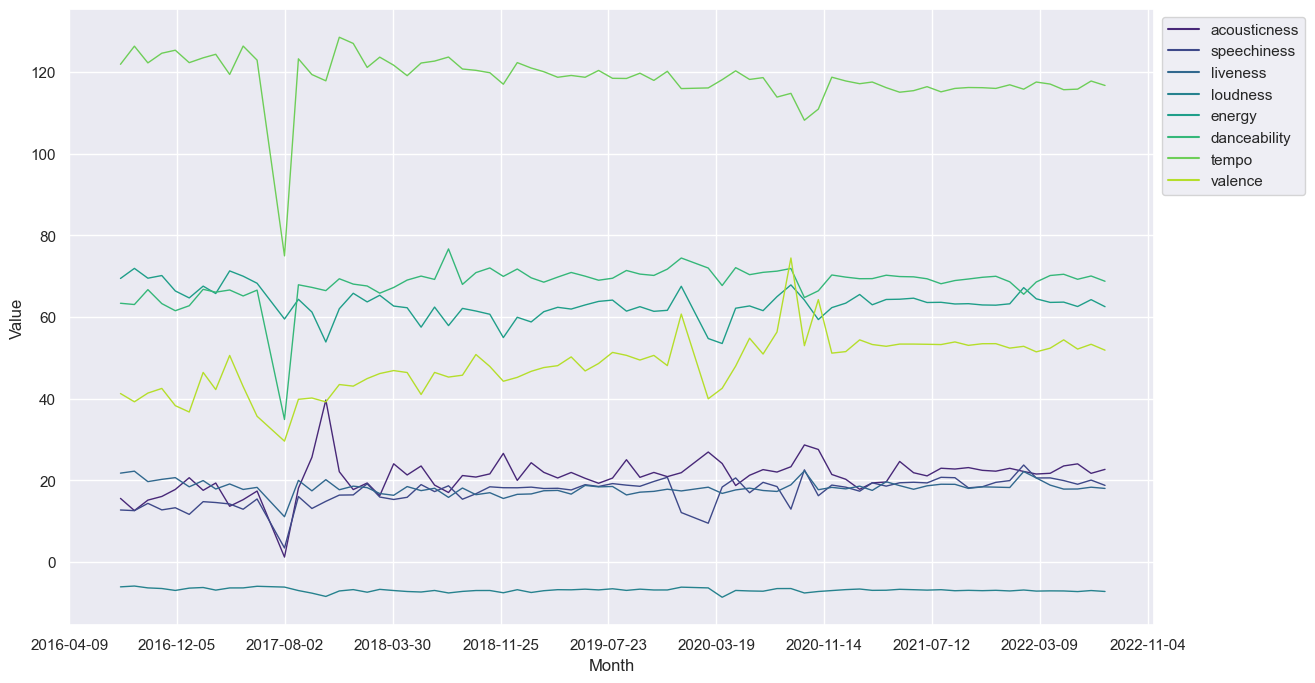

,year_month,audio_feature,value
0,2016-08-01,acousticness,15.584107
1,2016-09-01,acousticness,12.604572
2,2016-10-01,acousticness,15.163326
3,2016-11-01,acousticness,16.060053
4,2016-12-01,acousticness,17.777503
...,...,...,...
563,2022-04-01,valence,52.366796
564,2022-05-01,valence,54.397508
565,2022-06-01,valence,52.141871
566,2022-07-01,valence,53.315914


In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

#create year_month variable
finaldf['Date'] = pd.to_datetime(finaldf['Date'])
finaldf['year_month'] = finaldf['Date'].dt.strftime('%Y-%m')
finaldf['year_month']  = pd.to_datetime(finaldf['year_month'])


timeseries = finaldf.groupby(['year_month']).agg({'acousticness': ['mean'],'speechiness': ['mean'],'liveness': ['mean'],'loudness': ['mean'],
'energy': ['mean'],'danceability': ['mean'],'tempo': ['mean'],'valence': ['mean']}).reset_index()
timeseries.columns = timeseries.columns.droplevel(1)

features=['acousticness','speechiness','liveness','loudness','energy','danceability','tempo', 'valence']
timeseries = pd.melt(timeseries, id_vars=['year_month'], value_vars=features)
timeseries = timeseries.rename(columns = {'variable':'audio_feature'})
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=timeseries, x ='year_month', y = 'value',
                  hue='audio_feature', palette='viridis',
                  legend='full',lw=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) // 10])
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Value')
plt.xlabel('Month')

plt.show()
display(timeseries)

From the plot above, we can see how my listening has changed over the years. The average tempo of music per month, which measure the BPM of a song saw a large drop in August of 2017. We can also see a continuous increase in the average valence of the songs I listened to each month. Valence measures the positivity of a song so its nice to see how that has increased over time. Towards the end of 2017, we saw an increase in the acousticness of the songs I listened to. While this visualization is great, we need a more easily digestable visualization and or summary of data that can be easily digested by a regular music listener who may not have as strong a background in statistics. Lets see what a radial plot grouped by an average of each feature by year looks like

In [136]:
features = list(set(timeseries['audio_feature']))
pal = list(sns.color_palette(palette='YlGn', n_colors=len(features)).as_hex())
timeseries['Date_String'] = timeseries['year_month'].astype(str)
timeseries['Year'] = timeseries['Date_String'].str[:4]
yrs = list(set(timeseries['Year']))
lowerLimit = 0
max_v = timeseries['value'].max()

def radial_plot(input_df, column_name, title):
    input_df.reset_index(inplace=True, drop=True)
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
    plt.axis()
    heights = input_df[column_name]
    width = 2*np.pi / len(input_df.index)

    indexes = list(range(1, len(input_df.index)+1))
    angles = [element * width for element in indexes]

    bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit,
                  linewidth=1, edgecolor="white", color=pal)
    
    labelPadding = 2

    for bar, angle, height, label in zip(bars, angles, heights, features):
        rotation = np.rad2deg(angle)
        alignment = ""
      
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        ax.text(x=angle, y=lowerLimit + bar.get_height() + labelPadding,
                s=label, ha=alignment, va='center', rotation=rotation, 
                rotation_mode="anchor")
    
        ax.set_thetagrids([], labels=[])
        plt.title("Audio Features// " + title)
    return ax

[   Year audio_feature       value
0  2016  acousticness   15.437912
1  2016  danceability   63.580248
2  2016        energy   69.467842
3  2016      liveness   20.924587
4  2016      loudness   -6.338260
5  2016   speechiness   13.154495
6  2016         tempo  124.049459
7  2016       valence   40.531082,     Year audio_feature       value
8   2017  acousticness   19.148959
9   2017  danceability   63.614179
10  2017        energy   64.399934
11  2017      liveness   17.985411
12  2017      loudness   -6.752931
13  2017   speechiness   13.408198
14  2017         tempo  118.400503
15  2017       valence   40.629216,     Year audio_feature       value
16  2018  acousticness   20.691452
17  2018  danceability   69.530205
18  2018        energy   61.395621
19  2018      liveness   17.246997
20  2018      loudness   -7.123511
21  2018   speechiness   17.192642
22  2018         tempo  121.558690
23  2018       valence   45.738549,     Year audio_feature       value
24  2019  acousticness   

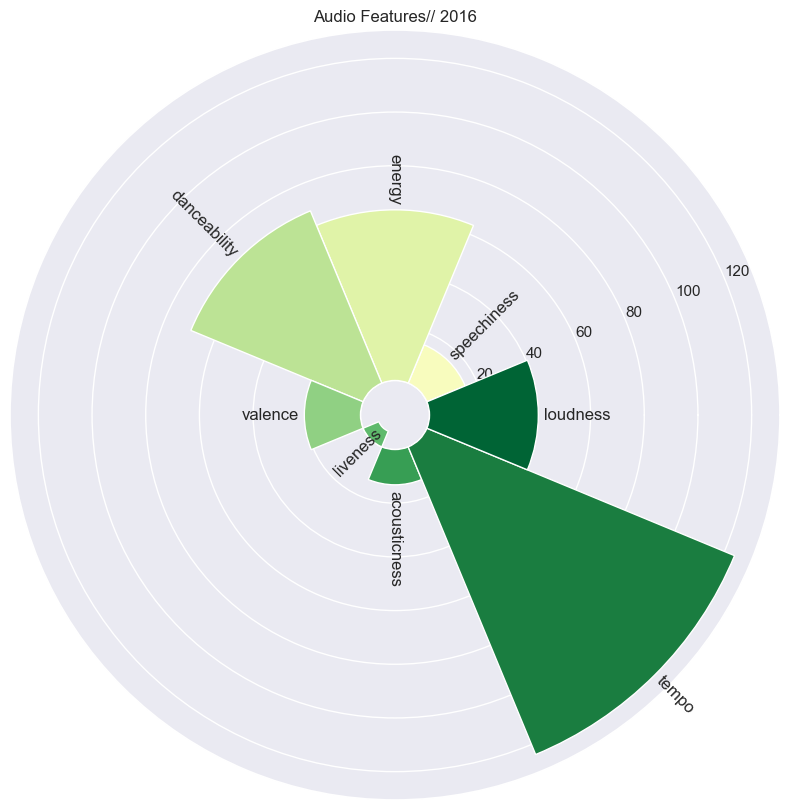

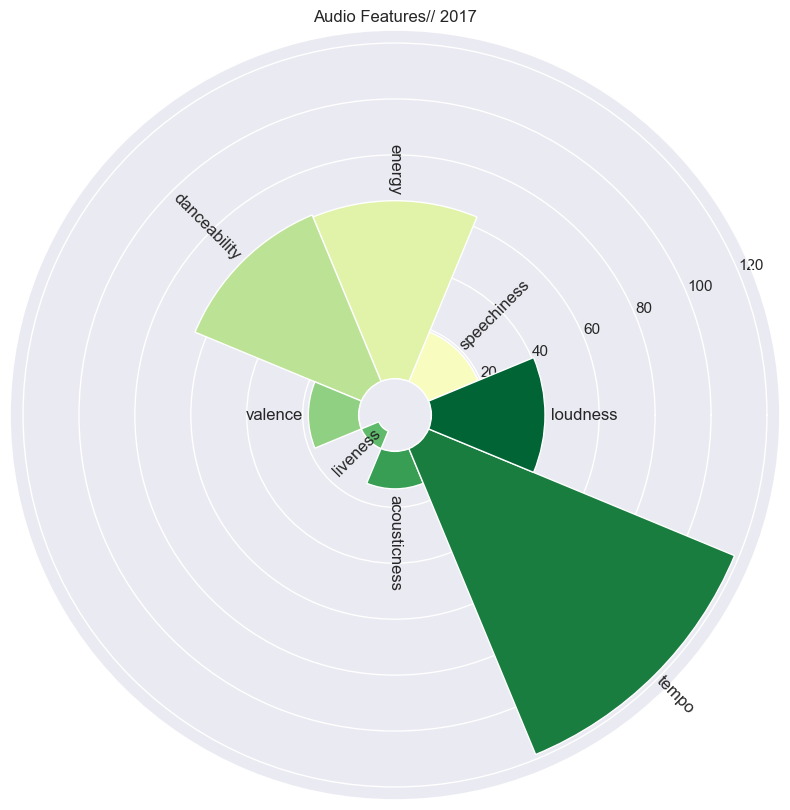

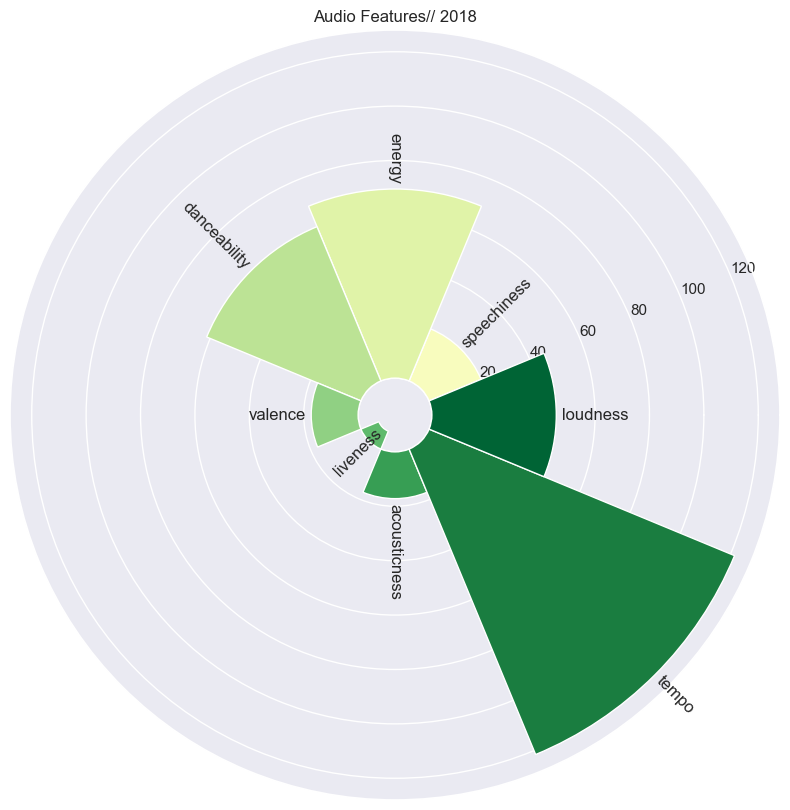

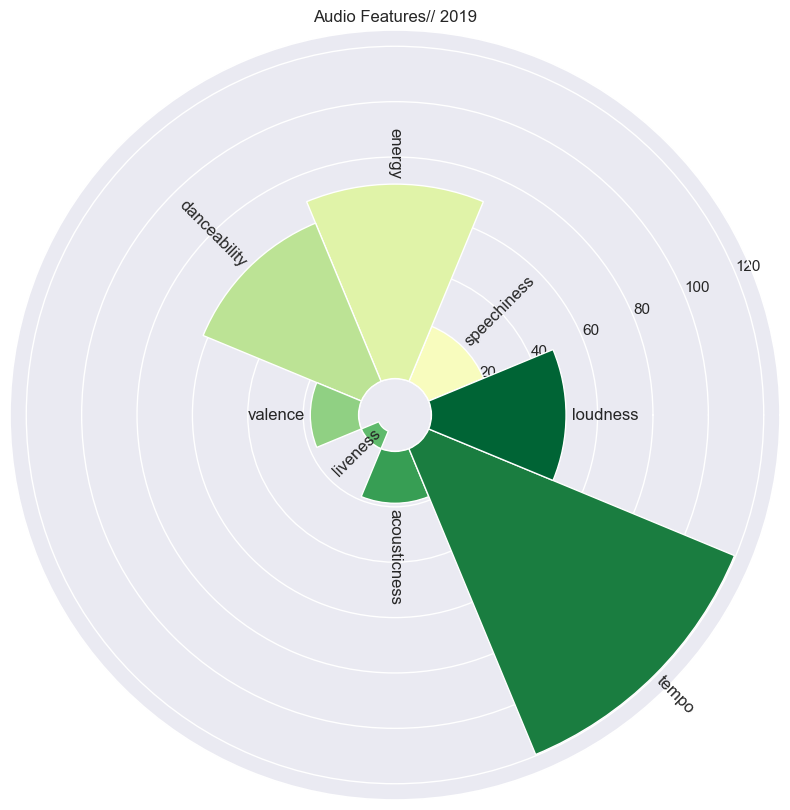

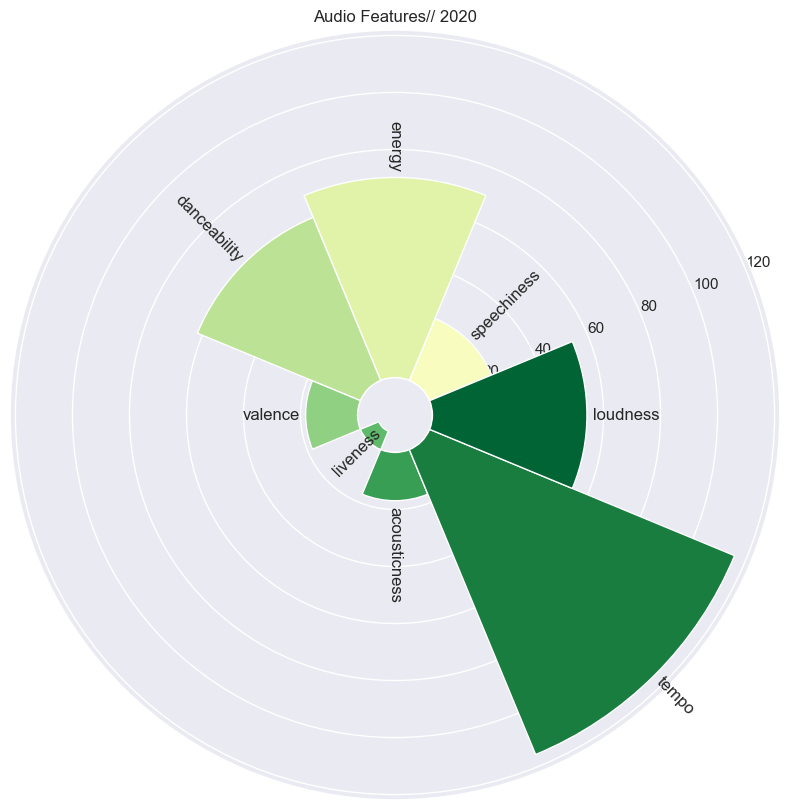

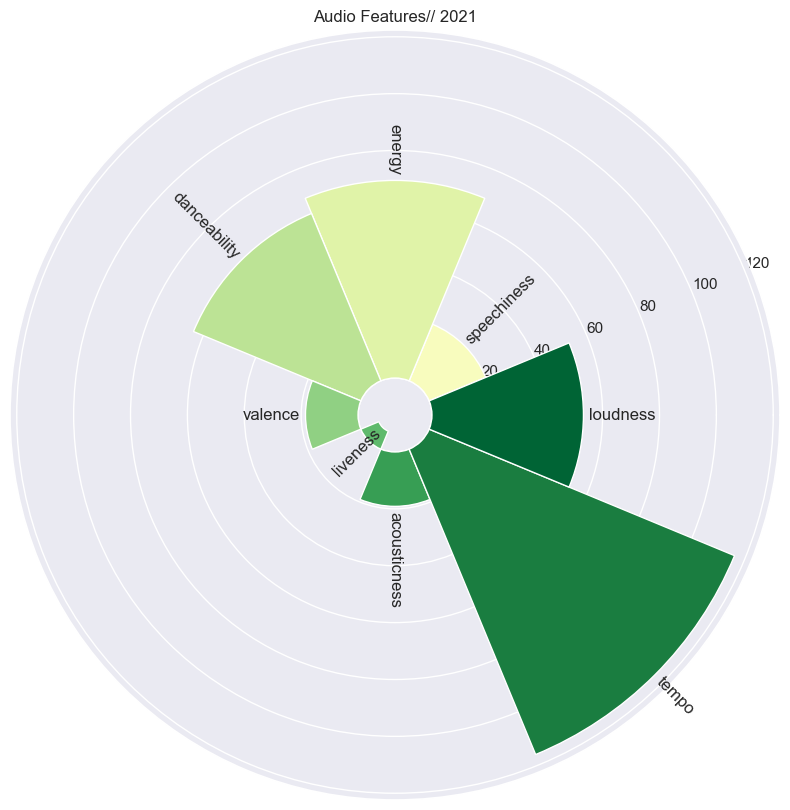

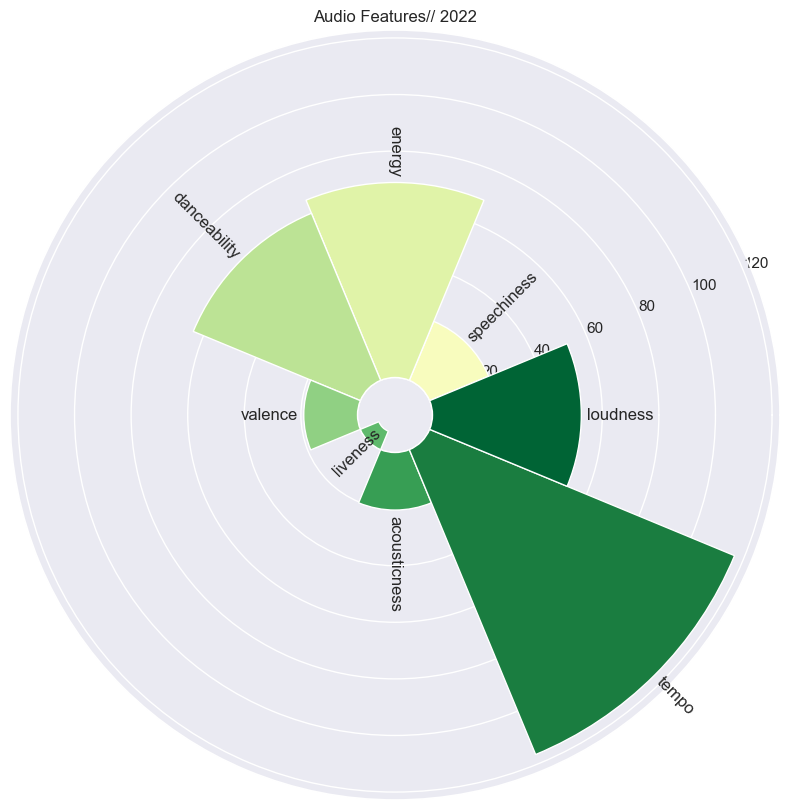

IndexError: list index out of range

In [142]:

order = range(len(timeseries))
listyr = list(set(timeseries['Year']))
listyr.sort()
timeseries1 =  timeseries.groupby(['Year','audio_feature']).agg({'value': ['mean']}).reset_index()
timeseries1.columns = timeseries1.columns.droplevel(1)

timeseriesls = [timeseries1[timeseries1['Year']==str(i)] for i in listyr]
print(timeseriesls)
for i in order:
    radial_plot(timeseriesls[i],'value',listyr[i])
    plt.show()


Expansion

These plots look nice, even though it is hard to digest in this format. For further expansion, I hope to put all of the radial plots in one planet so that its easier to visualize. Furthermore, I would like to make a similar plot but looking at different seasons as opposed to just years. There is still a lot to explore, including the possibility of a machine learning model that can predict the type of music you will listen to for any day/week/month/Season. Once I can create an effective and efficient method to pull the genres of each song, I also hope to run a PCA. Spotify gives a list of genres that are associated with an artist or album. Running a PCA to cluster these genres and find out which genres are most similar to each other. In addition to this, we can add the genres to a machine learning model as a variable to predict based on the audio features I have gathered for each song. Starting with a Two Way ANOVA test to see whether season and audio features have an effect on the genre of music I am listening to. Probably experiment with some classifiers(RandomForest, Logisitic Regression etc.) and generate some interesting looks into my music listening.